In [1]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
import numpy as np
from loader import load_def_sets
from neighborAnalysis import get_most_biased
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import string 
from sklearn.cluster import KMeans
import json
%matplotlib inline

In [2]:
def load_legacy_w2v_as_keyvecs(w2v_file, dim=50):
    vectors = None
    with open(w2v_file, 'r') as f:
        vectors = Word2VecKeyedVectors(dim)

        ws = []
        vs = []

        for line in f:
            vect = line.strip().rsplit()
            word = vect[0]
            vect = np.array([float(x) for x in vect[1:]])
            if(dim == len(vect)):
                ws.append(word)
                vs.append(vect)
        vectors.add_vectors(ws, vs, replace=True)
    return vectors


In [3]:
# From https://kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne
def tsne_plot(wv, focus_words):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    classes = []

    for i, (_, items) in enumerate(focus_words.items()):
        for word in items :
            tokens.append(wv.get_vector(word))
            labels.append(word)
            classes.append(i)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    colors = ['red','blue','green']
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i],color=colors[classes[i]])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()


def preprocessWordVecs(wv):
    """
    Following Bolukbasi:
    - only use the 50,000 most frequent words
    - only lower-case words and phrases
    - consisting of fewer than 20 lower-case characters
        (discard upper-case, digits, punctuation)
    - normalize all word vectors
    """
    newWordVecs = {}
    allowed = set(string.ascii_lowercase + ' ' + '_')

    for word, idx in wv.key_to_index.items():
        vec = wv.get_vector(word)
        chars = set(word)
        if chars.issubset(allowed) and len(word.replace('_', '')) < 20:
            newWordVecs[word] = vec / np.linalg.norm(vec)

    return newWordVecs


def get_race_directions(classes, embed_dim, word_vectors):
    vects = np.zeros((len(classes), embed_dim))
    for i, word in enumerate(classes):
        if word not in word_vectors:
            raise ValueError(word)
        vects[i] = word_vectors[word]
    mean = vects.mean(0)

    directions = np.zeros((len(classes), embed_dim))
    for i, word in enumerate(classes):
        directions[i] = word_vectors[word] - mean
        directions[i] = directions[i] / np.linalg.norm(directions[i])
        
    return directions 

def generate_max_biased_words(vectors, directions, num_words):
    positive_words = {}
    negative_words = {}

    print("computing bias of all words in each direction")
    for i, c in enumerate(classes):
        positive_bias, negative_bias = get_most_biased(vectors, directions[i], n_biased=50)
        #print(f"obtained {num_words} most positive- and negative-biased words for {c}")
        positive_words[c] = [x[0] for x in positive_bias]
        negative_words[c] = [x[0] for x in negative_bias]
    return positive_words, negative_words


def cluster(X1, random_state, y_true, num=2):
    kmeans_1 = KMeans(n_clusters=num, random_state=random_state).fit(X1)
    y_pred_1 = kmeans_1.predict(X1)
    correct = [1 if item1 == item2 else 0 for (item1,item2) in zip(y_true, y_pred_1) ]
    return max(sum(correct)/float(len(correct)), 1 - sum(correct)/float(len(correct)))

In [10]:
def_sets = load_def_sets('data/vocab/race_attributes_optm.json')
wv_pt = load_legacy_w2v_as_keyvecs("data/data_vocab_race_pre_trained.w2v")
wv_hd = load_legacy_w2v_as_keyvecs("data/data_vocab_race_hard_debias.w2v")
targets = json.load(open('data/professions.json', 'r'))
targets = [x[0] for x in targets]

original_vectors = preprocessWordVecs(wv_pt)
debiased_vectors = preprocessWordVecs(wv_hd)
embed_dim = wv_pt.vector_size

computing bias of all words in each direction
Calculating for set ['black', 'caucasian', 'asian']:
Original Precision: 0.8633333333333333, Hard Debias Precision: 0.6699999999999999, Delta: 0.19333333333333336


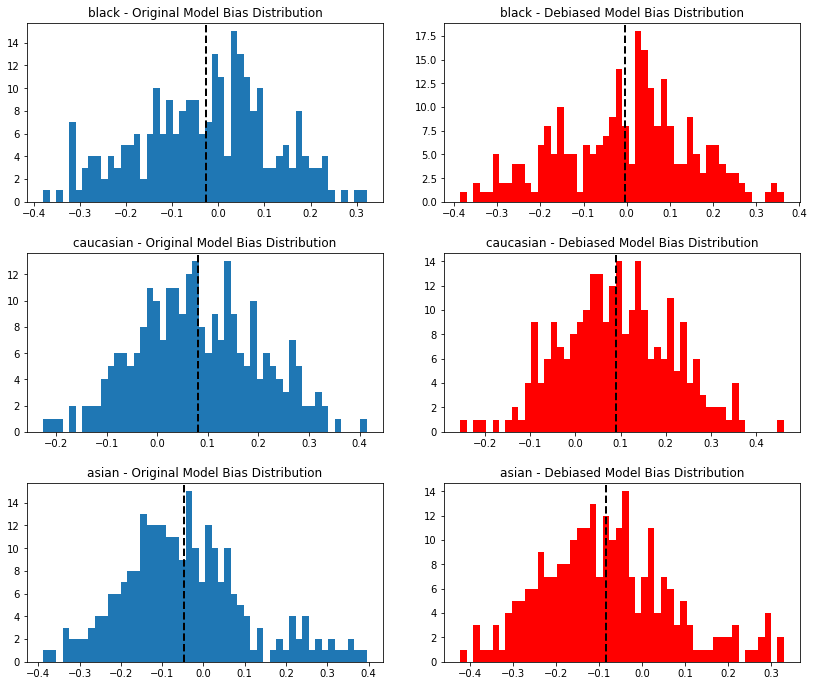

computing bias of all words in each direction
Calculating for set ['african', 'caucasian', 'asian']:
Original Precision: 0.51, Hard Debias Precision: 0.5066666666666666, Delta: 0.0033333333333334103


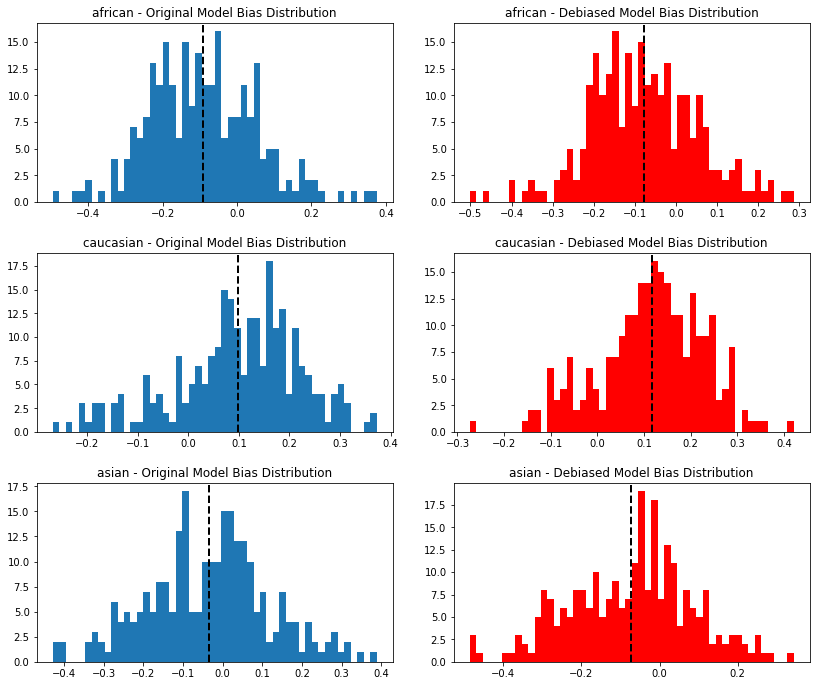

computing bias of all words in each direction
Calculating for set ['black', 'white', 'asian']:
Original Precision: 0.6033333333333333, Hard Debias Precision: 0.6, Delta: 0.0033333333333332993


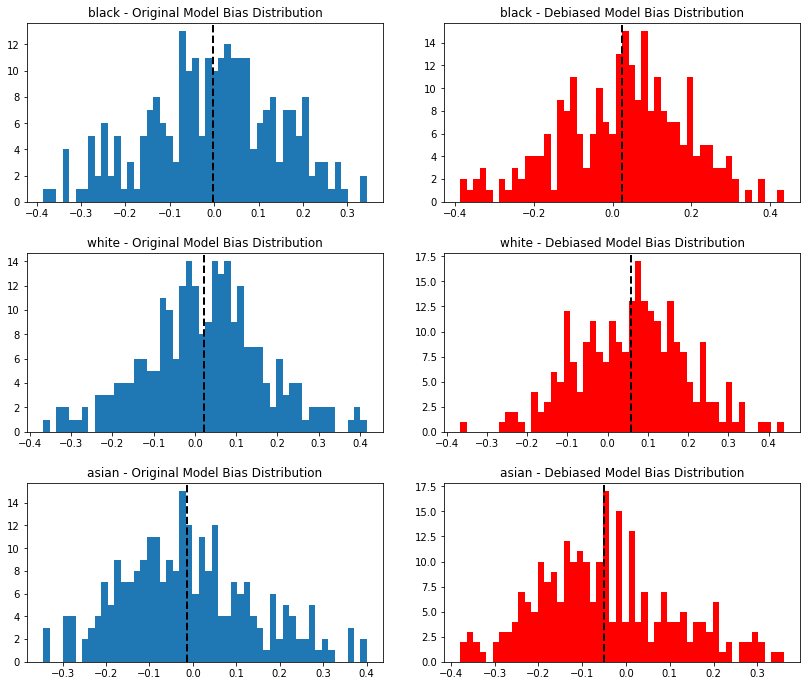

computing bias of all words in each direction
Calculating for set ['africa', 'america', 'asia']:
Original Precision: 0.6366666666666667, Hard Debias Precision: 0.5766666666666667, Delta: 0.06000000000000005


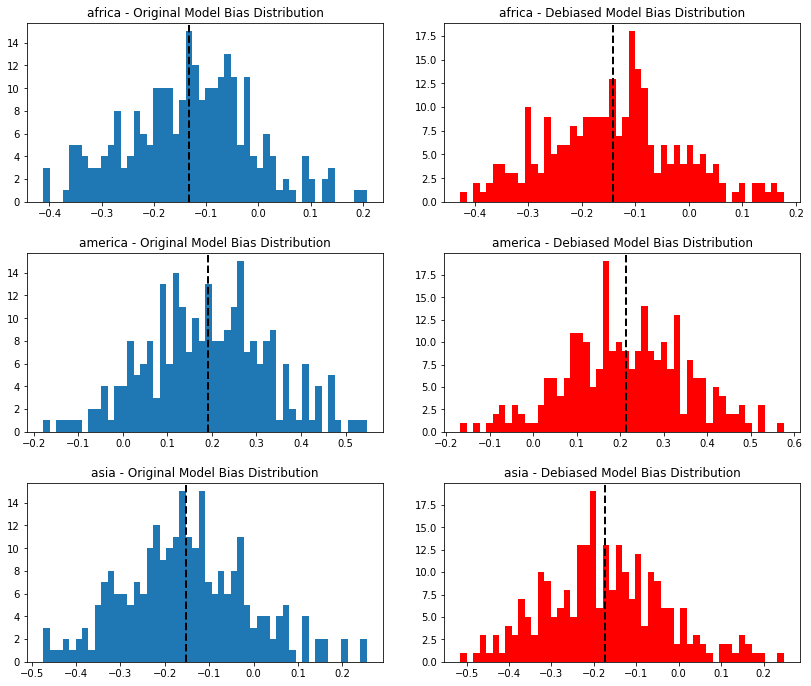

computing bias of all words in each direction
Calculating for set ['africa', 'america', 'china']:
Original Precision: 0.5033333333333334, Hard Debias Precision: 0.5033333333333334, Delta: 0.0


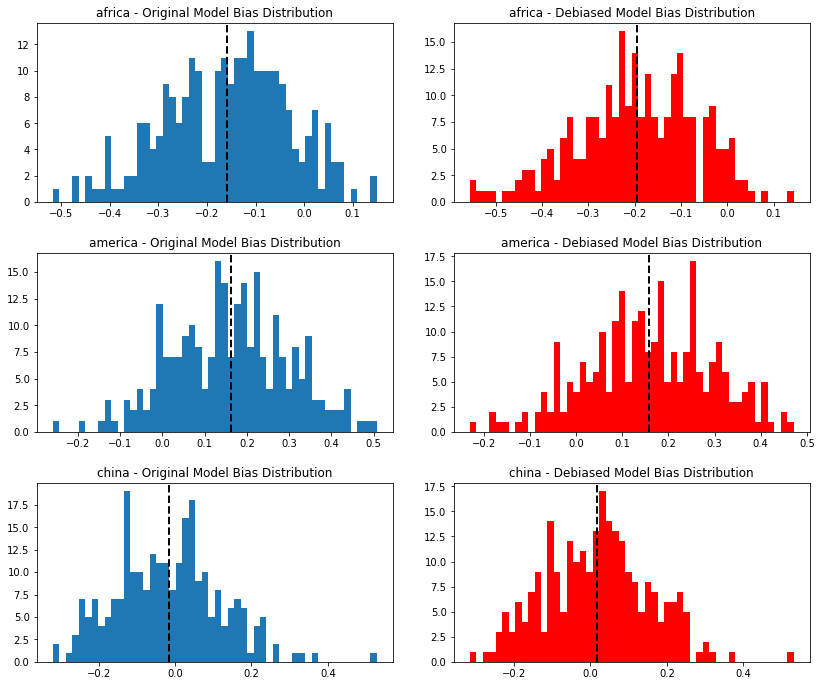

computing bias of all words in each direction
Calculating for set ['africa', 'europe', 'asia']:
Original Precision: 0.6599999999999999, Hard Debias Precision: 0.5066666666666666, Delta: 0.15333333333333332


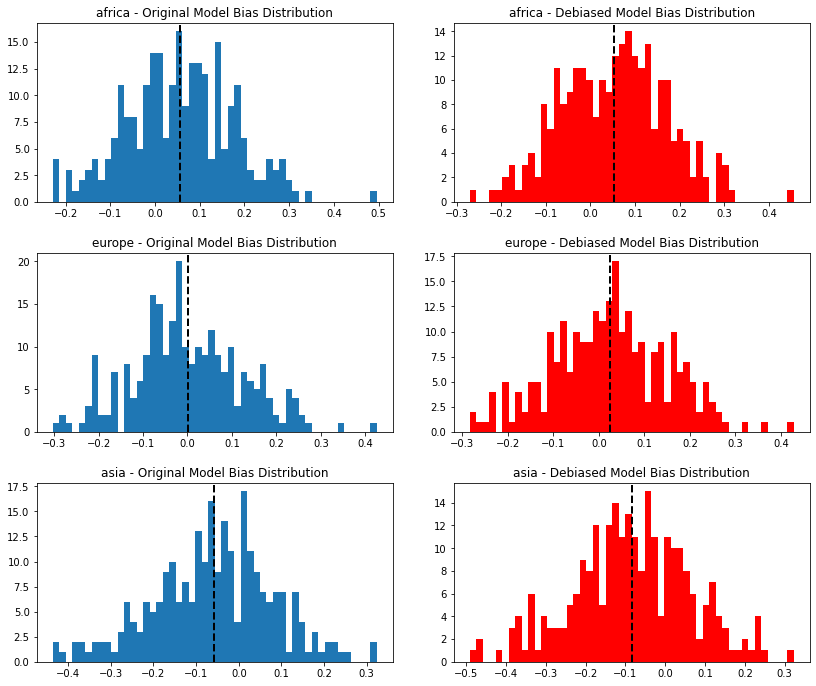

In [14]:
defined_sets = range(0, len(def_sets))
num_words = 100

for d in defined_sets:
    classes = def_sets[d]  # Should we average down the columns first across all defining sets?
    directions = get_race_directions(classes, embed_dim, original_vectors)
    positive_words, negative_words = generate_max_biased_words(original_vectors, directions, num_words)
    x_orig = []
    x_hd = []
    y_true = []

    for i, (_, items) in enumerate(positive_words.items()):
        for word in items :
            y_true.append(i)
            x_orig.append(original_vectors[word])
            x_hd.append(debiased_vectors[word])

    for i, (_, items) in enumerate(negative_words.items()):
        for word in items :
            y_true.append(i)
            x_orig.append(original_vectors[word])
            x_hd.append(debiased_vectors[word])

    print(f"Calculating for set {def_sets[d]}:")
    precision_orig = cluster(X1=np.array(x_orig), random_state=3, y_true=y_true, num=3)
    precision_hd = cluster(X1=np.array(x_hd), random_state=3, y_true=y_true, num=3)
    print(f"Original Precision: {precision_orig}, Hard Debias Precision: {precision_hd}, Delta: {precision_orig - precision_hd}")
    
    
    # compute bias for all targets
    target_bias = {}
    most_biased = {}
    most_anti_biased = {}
    
    target_bias_hd = {}
    most_biased_hd = {}
    most_anti_biased_hd = {}

    target_words = {}
    
    for i, c in enumerate(classes):
        
        target_bias[c] = {}
        target_bias_hd[c] = {}
        target_words[c] = []
        
        for word in targets:
            if word in original_vectors:    
                target_bias[c][word] = np.dot(original_vectors[word], directions[i])
                target_words[c].append(word) 
            if word in debiased_vectors:
                target_bias_hd[c][word] = np.dot(debiased_vectors[word], directions[i])
                target_words[c].append(word)    
        
    fig, axs = plt.subplots(3,2,figsize=(12,10))
    fig.tight_layout(pad=3.0)

    for i, (c, words) in enumerate(target_bias.items()):
        val = 0. # this is the value where you want the data to appear on the y-axis.
        ar = [sim for word, sim in words.items()]
        axs[i][0].set_title(f"{c} - Original Model Bias Distribution")
        axs[i][0].hist(ar, 50)
        axs[i][0].axvline(np.array(ar).mean(), color='k', linestyle='dashed', linewidth=2)


    for i, (c, words) in enumerate(target_bias_hd.items()):
        val = 0. # this is the value where you want the data to appear on the y-axis.
        ar = [sim for word, sim in words.items()]
        axs[i][1].set_title(f"{c} - Debiased Model Bias Distribution")
        axs[i][1].hist(ar, 50, color="red")
        axs[i][1].axvline(np.array(ar).mean(), color='k', linestyle='dashed', linewidth=2)

    plt.show()

    #tsne_plot(wv_pt, target_words)
    #tsne_plot(wv_hd, target_words)    